
# En este notebook se hace un análisis avanzado de random forest con la representación vectorial word2vec para dimensionalidad 100

In [ ]:
# To visualize plots in the notebook
%matplotlib inline

import numpy as np
import pandas as pd # To read data tables from csv files
import seaborn as sns # To plot statistical graphics
import matplotlib.pyplot as plt # To plot the figures
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

# For plots and graphical results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 6, 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
#data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

#en TF-IDF ya teníamos alta dimensionalidad, en w2v los datos datos tienen una dimensionalidad de 100, el texto de la receta no es tan largo ni complejo
#como para que con dimensionalidad 100 no sea posible cargar los datos.

# Cargar los embeddings desde el archivo guardado
w2v_directions = np.load('/content/drive/My Drive/Colab Notebooks/proyecto/w2v_embeddings.npy')

# Verifica el tamaño de los embeddings cargados
print(f"Tamaño de los embeddings: {w2v_directions.shape}")

Mounted at /content/drive
Tamaño de los embeddings: (20130, 100)


### **1. Preparación de los datos de entrenamiento y de test**

In [ ]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
target = target.fillna(target.mean())
X_train, X_test, y_train, y_test = train_test_split(w2v_directions, target, test_size=0.2, random_state=42)

0.0
5.0


### **2. Entrenamiento y evaluación**

#### ***2.1 Modelo de regresión con técnica de librería Scikit Learn***

##### *2.1.3 Random Forest*

In [ ]:
#para random forest no hay que normalizar los datos

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Búsqueda exhaustiva
# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y la mejor puntuación de validación cruzada

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}")

# Mejor modelo
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros encontrados: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación de validación cruzada: 0.1856268435155574


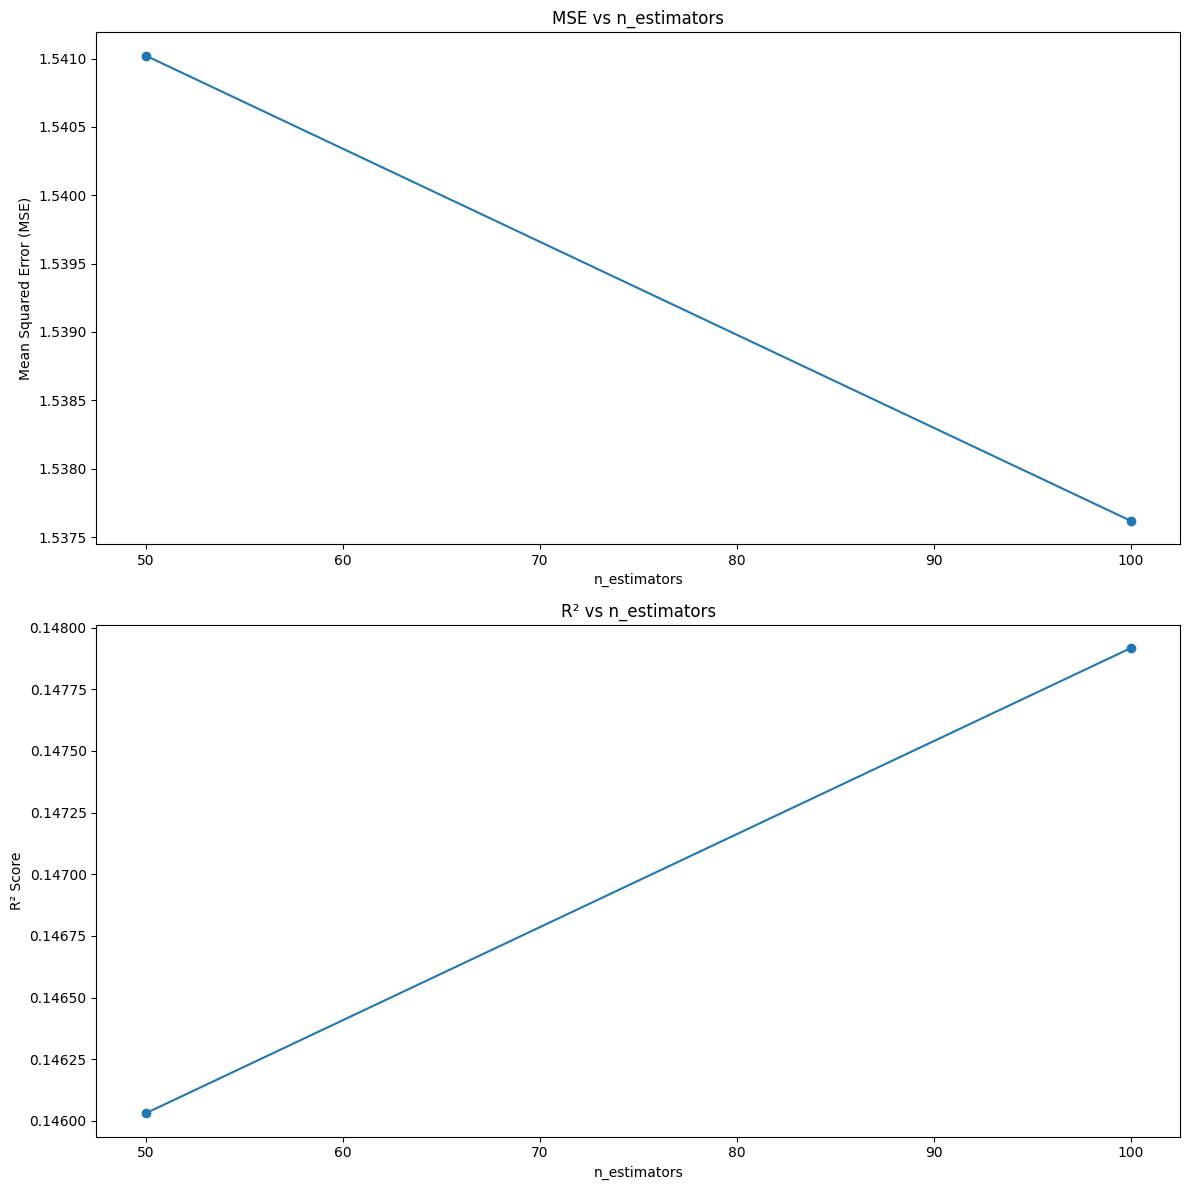

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Valores a probar para el hiperparámetro n_estimators
n_estimators_values = [50, 100]

# Almacenar los resultados
results = []

# Ciclo para probar diferentes valores de n_estimators
for n_estimators in n_estimators_values:
    # Entrenar y evaluar el modelo
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = model.predict(X_test)

    # Calcular MSE y R²
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar los resultados
    results.append({'n_estimators': n_estimators, 'mse': mse, 'r2': r2})

# Graficar los resultados: MSE y R² para diferentes valores de n_estimators
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Graficar MSE
ax[0].plot([result['n_estimators'] for result in results], [result['mse'] for result in results], marker='o')
ax[0].set_title("MSE vs n_estimators")
ax[0].set_xlabel("n_estimators")
ax[0].set_ylabel("Mean Squared Error (MSE)")

# Graficar R²
ax[1].plot([result['n_estimators'] for result in results], [result['r2'] for result in results], marker='o')
ax[1].set_title("R² vs n_estimators")
ax[1].set_xlabel("n_estimators")
ax[1].set_ylabel("R² Score")

plt.tight_layout()
plt.show()

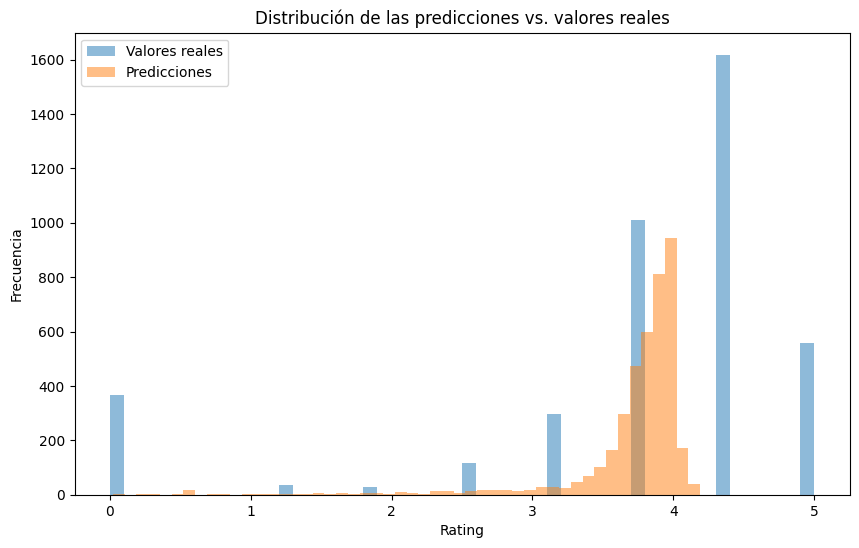

In [ ]:
#distribución valores reales rating vs predicciones
# Comparar distribuciones de las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label="Valores reales")
plt.hist(y_pred, bins=50, alpha=0.5, label="Predicciones")
plt.title("Distribución de las predicciones vs. valores reales")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()